# Seq2Seq Machine Translation

## Simple Encoder and Decoder

Under this section we will be implementing a simple encoder-decoder model for translating italian sequences to english sequences.

In [ ]:
# importing required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Loading Data

In [ ]:
# loading and unzipping the data
!wget http://www.manythings.org/anki/ita-eng.zip
!unzip ita-eng.zip

--2021-06-19 11:30:01--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.173.198, 104.21.55.222, 2606:4700:3036::ac43:adc6, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.173.198|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7645726 (7.3M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.29M  11.4MB/s    in 0.6s    

2021-06-19 11:30:02 (11.4 MB/s) - ‘ita-eng.zip’ saved [7645726/7645726]

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


In [ ]:
# reading the data and saving as df 

with open("/content/ita.txt",mode="r") as file:

    eng_txt = []
    itl_txt = []

    # extracting the english and italian texts
    for line in file.readlines():
        eng_txt.append(line.split("\t")[0])
        itl_txt.append(line.split("\t")[1])

df = pd.DataFrame(data={"eng":eng_txt,"itl":itl_txt})
df.head()    

,eng,itl
0,Hi.,Ciao!
1,Run!,Corri!
2,Run!,Corra!
3,Run!,Correte!
4,Who?,Chi?


In [ ]:
# shape of data
print(f"Shape of Data: {df.shape}") 

Shape of Data: (348324, 2)


### Processing Data

In [ ]:
# Functions to process eng and itl text data
# references:
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490
# https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd

import re

def decontractions(phrase):
    '''
    Function to expand deconctracted words
    '''
    
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def eng_preprocess(text):
    '''
    Function to preprocess english texts by converting them to lower characters, performing
    decontractions and removing special characters.
    '''
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def itl_preprocess(text):
    '''
    Function to preprocess italian texts by converting them to lower case and removing
    special characters
    '''
       
    text = text.lower()
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text

In [ ]:
# applying preprocessing functions
df['eng'] = df['eng'].apply(eng_preprocess)
df['itl'] = df['itl'].apply(itl_preprocess)
df.head()

,eng,itl
0,hi,ciao
1,run,corri
2,run,corra
3,run,correte
4,who,chi


In [ ]:
# length of text
df['eng_len'] = df['eng'].apply(lambda x: len(x.split()))
df['itl_len'] = df['itl'].apply(lambda x: len(x.split()))

df.head()

,eng,itl,eng_len,itl_len
0,hi,ciao,1,1
1,run,corri,1,1
2,run,corra,1,1
3,run,correte,1,1
4,who,chi,1,1


In [ ]:
# analysing sequence length percentiles
# english texts

# percentile values between 0 to 100 with step of 10
for i in range(0,110,10):
     val = np.percentile(df['eng_len'],i)
     print(f"{i} Percentile Value: {val}")


0 Percentile Value: 1.0
10 Percentile Value: 4.0
20 Percentile Value: 4.0
30 Percentile Value: 5.0
40 Percentile Value: 5.0
50 Percentile Value: 6.0
60 Percentile Value: 6.0
70 Percentile Value: 7.0
80 Percentile Value: 7.0
90 Percentile Value: 8.0
100 Percentile Value: 101.0


In [ ]:
# zooming in the range of 90 to 100

for i in range(90,101,1):
     val = np.percentile(df['eng_len'],i)
     print(f"{i} Percentile Value: {val}")

90 Percentile Value: 8.0
91 Percentile Value: 9.0
92 Percentile Value: 9.0
93 Percentile Value: 9.0
94 Percentile Value: 9.0
95 Percentile Value: 9.0
96 Percentile Value: 10.0
97 Percentile Value: 10.0
98 Percentile Value: 11.0
99 Percentile Value: 12.0
100 Percentile Value: 101.0


In [ ]:
# further zooming in the range of 99 to 100

p = 99
for i in range(10):
    p = round(p + 0.1, 2)
    val = np.percentile(df['eng_len'],p)
    print(f"{p} Percentile Value: {val}")

99.1 Percentile Value: 12.0
99.2 Percentile Value: 13.0
99.3 Percentile Value: 13.0
99.4 Percentile Value: 13.0
99.5 Percentile Value: 14.0
99.6 Percentile Value: 14.0
99.7 Percentile Value: 15.0
99.8 Percentile Value: 16.0
99.9 Percentile Value: 21.0
100.0 Percentile Value: 101.0


In [ ]:
# analysis sequence lengths percentiles
# italian texts

# percentile values between 0 to 100 with step of 10
for i in range(0,110,10):
     val = np.percentile(df['itl_len'],i)
     print(f"{i} Percentile Value: {val}")

0 Percentile Value: 1.0
10 Percentile Value: 3.0
20 Percentile Value: 4.0
30 Percentile Value: 4.0
40 Percentile Value: 5.0
50 Percentile Value: 5.0
60 Percentile Value: 6.0
70 Percentile Value: 6.0
80 Percentile Value: 7.0
90 Percentile Value: 8.0
100 Percentile Value: 92.0


In [ ]:
# zooming in the range of 90 to 100

for i in range(90,101,1):
     val = np.percentile(df['itl_len'],i)
     print(f"{i} Percentile Value: {val}")

90 Percentile Value: 8.0
91 Percentile Value: 8.0
92 Percentile Value: 8.0
93 Percentile Value: 9.0
94 Percentile Value: 9.0
95 Percentile Value: 9.0
96 Percentile Value: 10.0
97 Percentile Value: 10.0
98 Percentile Value: 11.0
99 Percentile Value: 12.0
100 Percentile Value: 92.0


In [ ]:
p = 99
for i in range(10):
    p = round(p + 0.1, 2)
    val = np.percentile(df['itl_len'],p)
    print(f"{p} Percentile Value: {val}")

99.1 Percentile Value: 12.0
99.2 Percentile Value: 12.0
99.3 Percentile Value: 13.0
99.4 Percentile Value: 13.0
99.5 Percentile Value: 13.0
99.6 Percentile Value: 14.0
99.7 Percentile Value: 15.0
99.8 Percentile Value: 16.0
99.9 Percentile Value: 20.0
100.0 Percentile Value: 92.0


As observed for both italian and english sequences around 99.9% of the sequences have a length of less than or equal to 20 characters. Hence we will use 20 as the maximum length for padding/truncating for both english and italian sequences

In [ ]:
# creating eng_input and eng_output columns
df['eng_input'] = df['eng'].apply(lambda x: "<start> " + x) 
df['eng_output'] = df['eng'].apply(lambda x: x + " <end>" )
df.head()

,eng,itl,eng_len,itl_len,eng_input,eng_output
0,hi,ciao,1,1,<start> hi,hi <end>
1,run,corri,1,1,<start> run,run <end>
2,run,corra,1,1,<start> run,run <end>
3,run,correte,1,1,<start> run,run <end>
4,who,chi,1,1,<start> who,who <end>


In [ ]:
# adding <start> & <end> special characters to eng text
df['eng'] = df['eng'].apply(lambda x: "<start> " + x + " <end>" )
df.head()

,eng,itl,eng_len,itl_len,eng_input,eng_output
0,<start> hi <end>,ciao,1,1,<start> hi,hi <end>
1,<start> run <end>,corri,1,1,<start> run,run <end>
2,<start> run <end>,corra,1,1,<start> run,run <end>
3,<start> run <end>,correte,1,1,<start> run,run <end>
4,<start> who <end>,chi,1,1,<start> who,who <end>


In [ ]:
# dropping columns not required
df.drop(labels=["eng_len","itl_len"],axis=1,inplace=True)
df.head()

,eng,itl,eng_input,eng_output
0,<start> hi <end>,ciao,<start> hi,hi <end>
1,<start> run <end>,corri,<start> run,run <end>
2,<start> run <end>,corra,<start> run,run <end>
3,<start> run <end>,correte,<start> run,run <end>
4,<start> who <end>,chi,<start> who,who <end>


In [ ]:
# splitting into train and test
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df,test_size=0.2,random_state=23)
print(f"Number of Points in Train Data: {df_train.shape[0]}")
print(f"Number of Points in Test Data: {df_test.shape[0]}")

Number of Points in Train Data: 278659
Number of Points in Test Data: 69665


In [ ]:
# fitting tokenizer on encoder and decoder sequences

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer_itl = Tokenizer(num_words=None,
                          filters='!"#$%&()*+,-./:;_=?@[\\]^`{|}~\t\n') # filter inludes all special characters except '<>'

tokenizer_itl.fit_on_texts(df_train['itl'].values)

tokenizer_eng = Tokenizer(num_words=None,
                          filters='!"#$%&()*+,-./:;_=?@[\\]^`{|}~\t\n') # filter inludes all special characters except '<>' 
tokenizer_eng.fit_on_texts(df_train['eng'].values)

In [ ]:
# data pipelines

class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['itl'].values
        self.decoder_inps = data['eng_input'].values
        self.decoder_outs = data['eng_output'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
# settin up tensorboard

%load_ext tensorboard
import datetime

def tf_callback(model_num=None):
    '''
    This function returns a tensorboard callback object
    '''
    
    # specifiying the directory structure and instantiating tensorboard callback object
    log_dir = f"logs/fit/{model_num}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    return cb

### Model Implementation

#### Encoder

In [ ]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal

regularizer = l2(0.0001)
initializer = HeNormal()

class Encoder(tf.keras.layers.Layer):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        # initializing input variables and required layers 

        super().__init__()
        self.lstm_units = lstm_size
        self.embedding = Embedding(input_dim=inp_vocab_size,output_dim=embedding_size,input_length=input_length,
                                   mask_zero=True)        
        self.lstm = LSTM(units=self.lstm_units,recurrent_initializer=initializer,recurrent_regularizer=regularizer,
                         return_sequences=True,return_state=True, dropout=0.3)


    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''

        # passing encoder inputs through embedding and lstm layers

        embedding_vectors = self.embedding(input_sequence)
        encoder_output, state_h, state_c = self.lstm(inputs=embedding_vectors,initial_state=states)

        return encoder_output, state_h, state_c 


    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      initial_h =  tf.zeros(shape=[batch_size,self.lstm_units]) # initial hidden state
      initial_c =  tf.zeros(shape=[batch_size,self.lstm_units]) # initial cell state

      return [initial_h, initial_c]

In [ ]:
class Decoder(tf.keras.layers.Layer):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):

        # initializing input variables and required layers
        
        super().__init__()
        self.lstm_units = lstm_size
        self.embedding = Embedding(input_dim=out_vocab_size, output_dim=embedding_size, mask_zero=True,
                                   input_length=input_length)
        self.lstm = LSTM(units=self.lstm_units, recurrent_initializer=initializer, recurrent_regularizer=regularizer,
                        return_sequences=True, return_state=True,dropout=0.3)


    def call(self,input_sequence,initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        
          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''

        # passing decoder inputs through embedding and lstm layers 

        embedding_vectors = self.embedding(input_sequence)
        decoder_output, decoder_final_state_h, decoder_final_state_c = self.lstm(inputs=embedding_vectors,initial_state=initial_states)

        return decoder_output, decoder_final_state_h, decoder_final_state_c

In [ ]:
from tensorflow.keras.layers import Dense

encoder_max = len(tokenizer_itl.word_index) 
decoder_max = len(tokenizer_eng.word_index)

class Encoder_decoder(tf.keras.Model):
    
    def __init__(self,batch_size):

        # initialzing encoder-decoder objects and dense layer
        super().__init__()
        self.encoder = Encoder(encoder_max + 1,embedding_size=100,lstm_size=128,input_length=20)
        self.decoder = Decoder(decoder_max + 1,embedding_size=100,lstm_size=128,input_length=20)
        self.dense = Dense(decoder_max + 1,activation="softmax",kernel_initializer=initializer)
        self.batch_size = batch_size
    
    
    def call(self,inputs):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''

        encoder_input, decoder_input = inputs[0], inputs[1]

        # passing input sequence to encoder
        encoder_initial = self.encoder.initialize_states(self.batch_size)
        encoder_output, encoder_final_state_h, encoder_final_state_c = self.encoder(encoder_input,encoder_initial)
        states = [encoder_final_state_h, encoder_final_state_c]

        # passing tagret sequence and initial states to decoder
        decoder_output, _, _ = self.decoder(decoder_input,states)

        # passing decoder output to dense layer
        output = self.dense(decoder_output)

        return output          

In [ ]:
# train and test data loader

train_dataset = Dataset(df_train,tokenizer_itl,tokenizer_eng,20)
test_dataset = Dataset(df_test,tokenizer_itl,tokenizer_eng,20)

train_dataloader = Dataloder(train_dataset,batch_size=1024)
test_dataloader = Dataloder(test_dataset,batch_size=1024)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [ ]:
# train and test steps in each epoch

train_steps = df_train.shape[0] // 1024
test_steps = df_test.shape[0] // 1024

In [ ]:
# defining callbacks
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss",patience=2,mode="min")
tensorboard = tf_callback(model_num=1)
callbacks = [early_stop,tensorboard]

In [ ]:
# clearing backend session
tf.keras.backend.clear_session()

# compiling the model and training
model = Encoder_decoder(batch_size=1024)
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')

# training the model
model.fit_generator(train_dataloader,steps_per_epoch=train_steps,epochs=50,validation_data=test_dataloader,validation_steps=test_steps,callbacks=callbacks)

Epoch 1/50
272/272 [==============================] - 71s 240ms/step - loss: 1.9120 - val_loss: 1.5043
Epoch 2/50
272/272 [==============================] - 63s 230ms/step - loss: 1.3457 - val_loss: 1.1993
Epoch 3/50
272/272 [==============================] - 63s 232ms/step - loss: 1.1127 - val_loss: 1.0025
Epoch 4/50
272/272 [==============================] - 63s 232ms/step - loss: 0.9469 - val_loss: 0.8561
Epoch 5/50
272/272 [==============================] - 63s 231ms/step - loss: 0.8213 - val_loss: 0.7431
Epoch 6/50
272/272 [==============================] - 63s 231ms/step - loss: 0.7225 - val_loss: 0.6547
Epoch 7/50
272/272 [==============================] - 63s 230ms/step - loss: 0.6428 - val_loss: 0.5828
Epoch 8/50
272/272 [==============================] - 63s 231ms/step - loss: 0.5784 - val_loss: 0.5272
Epoch 9/50
272/272 [==============================] - 63s 231ms/step - loss: 0.5260 - val_loss: 0.4826
Epoch 10/50
272/272 [==============================] - 63s 230ms/step - l

In [ ]:
def predict(input_sentence):
    '''
    Function to predict the translated sentence given an input sentence
    '''
    # getting the context vector from the encoder
    encoder_input = [input_sentence]
    encoder_input = tokenizer_itl.texts_to_sequences(encoder_input)
    encoder_input = pad_sequences(encoder_input,maxlen=20)
    encoder_initial = model.layers[0].initialize_states(1)
    encoder_output, state_h, state_c = model.layers[0](encoder_input,encoder_initial)
    states = [state_h,state_c]

    # initializing first word as <start> for the decoder
    cur_word = "<start>"
    pred_sentence = ""

    # predicting words unless current word is <end>
    while cur_word != "<end>":

        # getting the current word output and states
        decoder_input = np.array(tokenizer_eng.texts_to_sequences([cur_word]))
        decoder_output, state_h, state_c = model.layers[1](decoder_input,states)

        # updating states and predicting word 
        states = [state_h,state_c]
        output = model.layers[2](decoder_output)
        index = np.argmax(output)
        pred_word = tokenizer_eng.sequences_to_texts([[index]])[0]

        # updating the current word and adding it to predicted sentence
        cur_word = pred_word
        pred_sentence = pred_sentence + pred_word + " " 
    
    pred_sentence = pred_sentence.strip()
    
    return pred_sentence

**Computing Bleu Score**

In [ ]:
from nltk.translate.bleu_score import sentence_bleu as bleu


def bleu_score(reference,translation):
    '''
    Function to compute bleu score given a reference
    and translation text
    '''

    reference = [reference.split()] # true sentence
    translation = translation.split() # predicted

    return bleu(reference,translation)


In [ ]:
def test_bleu(num_samples,data):
    '''
    Function to compute the bleu score for 
    random sentences in test data
    '''

    # sampling random points from dataset
    sample_df = data.sample(num_samples) 
    sample_df = sample_df[["itl","eng_output"]]

    scores = []

    # looping through all sample points
    for index,row in sample_df.iterrows():
        input_sentence,target_sentence = row 

        # predicting using model
        pred_sentence = predict(input_sentence)

        if len(pred_sentence) == 2:
          pred_sentence = pred_sentence[0]

        # calculating bleu score
        score = bleu_score(target_sentence,pred_sentence)
        scores.append(score)
    
    # finding average score
    avg_score = np.mean(scores)

    return scores,avg_score

In [ ]:
all_scores, avg_score = test_bleu(1000,df_test)
print(f'Average Blue Score for 1000 test samples: {avg_score}')

Average Blue Score for 1000 test samples: 0.7855177188221155


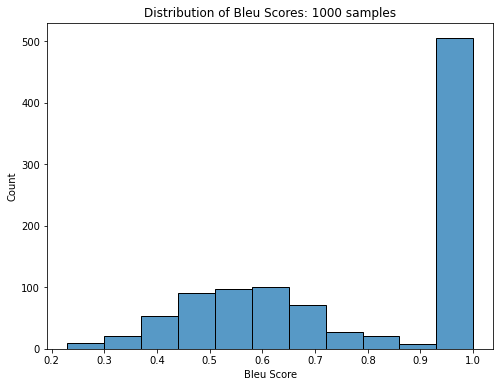

In [ ]:
# plotting distribution of Bleu Score 
plt.figure(figsize=(8,6))
plt.title("Distribution of Bleu Scores: 1000 samples")
plt.xlabel("Bleu Score")
sns.histplot(all_scores)
plt.show()

## Attention Mechanism

Under this section we will be adding attention mechanism to our encoder-decoder architecture. We will be implementing three different models based on the following strategies to calculate attention weights:

- Dot 
- General 
- Concat

### Model Implementation

#### Encoder

In [ ]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal

regularizer = l2(0.0001)
initializer = HeNormal()

class Encoder(tf.keras.layers.Layer):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        # initializing input variables and required layers 

        super().__init__()
        self.lstm_units = lstm_size
        self.embedding = Embedding(input_dim=inp_vocab_size,output_dim=embedding_size,input_length=input_length,
                                   mask_zero=True)        
        self.lstm = LSTM(units=self.lstm_units,recurrent_initializer=initializer,recurrent_regularizer=regularizer,
                         return_sequences=True,return_state=True, dropout=0.3)


    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''

        # passing encoder inputs through embedding and lstm layers

        embedding_vectors = self.embedding(input_sequence)
        encoder_output, state_h, state_c = self.lstm(inputs=embedding_vectors,initial_state=states)

        return encoder_output, state_h, state_c 


    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      initial_h =  tf.zeros(shape=[batch_size,self.lstm_units]) # initial hidden state
      initial_c =  tf.zeros(shape=[batch_size,self.lstm_units]) # initial cell state

      return [initial_h, initial_c]

#### Attention Logic

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import GlorotNormal

regularizer = l2(0.0001)
initializer = GlorotNormal()

class Attention(tf.keras.layers.Layer):
    '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
    '''

    def __init__(self,scoring_function,att_units):

        # initializing attention layer
        super().__init__()
        self.scoring_function = scoring_function
        self.att_units = att_units

        if self.scoring_function=='dot':
            # initializing variables for dot product
            self.dot_1 = tf.keras.layers.Dot(axes=(2,1))
            self.dot_2 = tf.keras.layers.Dot(axes=(1,1))
            self.softmax = tf.keras.layers.Softmax()

        elif self.scoring_function == "general":
            # initializing variables for general scoring
            self.dot_1 = tf.keras.layers.Dot(axes=(2,1))
            self.dot_2 = tf.keras.layers.Dot(axes=(1,1))
            self.w = tf.keras.layers.Dense(units=self.att_units,kernel_initializer=initializer,kernel_regularizer=regularizer)
            self.softmax = tf.keras.layers.Softmax()

        elif self.scoring_function == "concat":
            # initializing variables for concat scoring
            self.w1 = tf.keras.layers.Dense(units=self.att_units,kernel_initializer=initializer,kernel_regularizer=regularizer)
            self.w2 = tf.keras.layers.Dense(units=self.att_units,kernel_initializer=initializer,kernel_regularizer=regularizer)
            self.tanh = tf.keras.layers.Activation(activation="tanh")
            self.v = tf.keras.layers.Dense(units=1)
            self.softmax = tf.keras.layers.Softmax(axis=1)
            self.dot = tf.keras.layers.Dot(axes=(1,1))
            
            
    
    def call(self,decoder_hidden_state,encoder_output):
        '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
        '''

        if self.scoring_function == 'dot':
        
            # implementing dot score function
            similarity = self.dot_1([encoder_output,decoder_hidden_state])
            attn_weights = self.softmax(similarity)
            context_vector = self.dot_2([attn_weights,encoder_output])

            # expanding dimension of attn_weights
            attn_weights = tf.expand_dims(attn_weights,axis=-1)

            return context_vector, attn_weights 
        
        elif self.scoring_function == "general":
            
            # implementing general score function
            dense_output = self.w(encoder_output)
            similarity = self.dot_1([dense_output,decoder_hidden_state]) 
            attn_weights = self.softmax(similarity)
            context_vector = self.dot_2([attn_weights,encoder_output])

            # expanding dimension of attn_weights
            attn_weights = tf.expand_dims(attn_weights,axis=-1)

            return context_vector, attn_weights



        
        elif self.scoring_function == "concat":
            
            # implementing concat score function

            # weights multiplication
            dense_encoder = self.w1(encoder_output)
            dense_decoder = self.w2(decoder_hidden_state)

            # concatenation of encoder and decoder
            dense_decoder = dense_decoder[:,None,:]
            concat = dense_encoder + dense_decoder
            concat_output = self.v(self.tanh(concat))
            attn_weights = self.softmax(concat_output)
            context_vector = self.dot([attn_weights,encoder_output])

            # squeezing dimensions of context vector
            context_vector = tf.squeeze(context_vector,axis=1)

            return context_vector, attn_weights




#### OneStep Decoder

In [ ]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal

regularizer = l2(0.0001)
initializer = HeNormal()


class One_Step_Decoder(tf.keras.layers.Layer):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):

      # initializing variables for one-step-decoder

      super().__init__()
      self.lstm_units = dec_units
      self.att_units = att_units
      self.scoring_fun = score_fun
      self.embedding = Embedding(input_dim=tar_vocab_size, output_dim=embedding_dim,mask_zero=True,input_length=input_length)
      self.lstm = LSTM(units=self.lstm_units,recurrent_initializer=initializer,recurrent_regularizer=regularizer,
                       return_sequences=True,return_state=True, dropout=0.3)
      self.attention = Attention(self.scoring_fun,self.att_units)
      self.concat = tf.keras.layers.Concatenate(axis=2)
      self.dense = tf.keras.layers.Dense(units=tar_vocab_size)



  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder    embedding_vector = self.embedding(input_to_decoder)
    context_vector, attn_weights = self.attention(state_h,encoder_output)
    concat_input = self.concat([embedding_vector,context_vector])
    decoder_output, state_h, state_c = self.lstm(inputs=concat_input,initial_state=[state_h,state_c])
    output = self.dense(decoder_output) to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''

    # embedding vector of decoder input
    embedding_vector = self.embedding(input_to_decoder)

    # context vector and attention weights
    context_vector, attn_weights = self.attention(state_h,encoder_output)
    context_vector_exp = tf.expand_dims(context_vector,axis=1)

    # concat context vector + decoder embedding for final output
    concat_input = self.concat([embedding_vector,context_vector_exp])
    decoder_output, state_h, state_c = self.lstm(inputs=concat_input,initial_state=[state_h,state_c])
    output = self.dense(decoder_output)

    # squeezing dimensions of output
    output = tf.squeeze(output)

    return  output, state_h, state_c, attn_weights, context_vector


#### Decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):

      # initializing necessary variables 
      super().__init__()
      self.out_vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.score_fun = score_fun
      self.att_units = att_units
      self.dec_units = dec_units
      self.onestepdecoder = One_Step_Decoder(self.out_vocab_size,self.embedding_dim,self.input_length,
                                             self.dec_units,self.score_fun,self.att_units)
      
      

    
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):
        '''
        Function returns output vector of shape (batch_size, input_length, vocab_size)
        given a sequence of decoder input
        '''

        # initializing empty tensor array to store outputs at each time step
        all_outputs = tf.TensorArray(tf.float32,size=tf.shape(input_to_decoder)[1])
        

        # looping through all time steps in decoder input        
        for timestamp in range(tf.shape(input_to_decoder)[1]):
            output, decoder_hidden_state, decoder_cell_state, attn_weights, context_vector  = self.onestepdecoder(input_to_decoder[:,timestamp:timestamp + 1],encoder_output,
                                                                                                                  decoder_hidden_state,decoder_cell_state)
            # writing data to tensor array
            all_outputs = all_outputs.write(timestamp,output)
        
        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2])

        return all_outputs

#### Encoder Decoder Model with Attention

In [ ]:
encoder_max = len(tokenizer_itl.word_index) 
decoder_max = len(tokenizer_eng.word_index)

class encoder_decoder(tf.keras.Model):
  def __init__(self,batch_size,score_fun):
    
    # initializing required variables

    super().__init__()
    self.batch_size = batch_size
    self.score_fun = score_fun
    self.encoder = Encoder(encoder_max + 1, embedding_size=100,lstm_size=128,input_length=20)
    self.decoder = Decoder(decoder_max + 1,embedding_dim=100,input_length=20,dec_units=128,score_fun=self.score_fun,att_units=128)

  
  def call(self,data):
    '''
    Function that takes encoder and decoder sequences as input, computes context vector/attention weights
    to return final decoder output
    ''' 
    
    encoder_input, decoder_input = data[0], data[1]

    # passing input sequence to encoder
    encoder_initial = self.encoder.initialize_states(self.batch_size)
    encoder_output, state_h, state_c = self.encoder(encoder_input,encoder_initial)

    # passing encoder_output and states to decoder
    decoder_output = self.decoder(decoder_input,encoder_output,state_h,state_c)

    # returning the final output
    return decoder_output

#### Custom Loss Function

In [ ]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    '''
    Function to implement custom error/loss metric to minimize
    '''
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Training - Dot Method

In [ ]:
# train and test data loader

train_dataset = Dataset(df_train,tokenizer_itl,tokenizer_eng,20)
test_dataset = Dataset(df_test,tokenizer_itl,tokenizer_eng,20)

train_dataloader = Dataloder(train_dataset,batch_size=1024)
test_dataloader = Dataloder(test_dataset,batch_size=1024)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [ ]:
train_steps = df_train.shape[0] // 1024
test_steps = df_test.shape[0] // 1024

In [ ]:
# defining callbacks

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor="val_loss",patience=2,mode="min")
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5,min_delta=0.005,min_lr=1e-8)
tensorboard = tf_callback(model_num=2)
callbacks = [early_stop,tensorboard, reduce_lr]

In [ ]:
# Compile the model and fit the model

tf.keras.backend.clear_session()
model = encoder_decoder(batch_size=1024,score_fun="dot")
optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(optimizer=optimizer,loss=loss_function)
model.fit_generator(train_dataloader,steps_per_epoch=train_steps,epochs=50,validation_data=test_dataloader,validation_steps=test_steps,callbacks=callbacks)


Epoch 1/50
272/272 [==============================] - 112s 389ms/step - loss: 1.9890 - val_loss: 1.6717
Epoch 2/50
272/272 [==============================] - 102s 376ms/step - loss: 1.5389 - val_loss: 1.3859
Epoch 3/50
272/272 [==============================] - 102s 375ms/step - loss: 1.2712 - val_loss: 1.1447
Epoch 4/50
272/272 [==============================] - 111s 409ms/step - loss: 1.0759 - val_loss: 0.9838
Epoch 5/50
272/272 [==============================] - 102s 374ms/step - loss: 0.9391 - val_loss: 0.8623
Epoch 6/50
272/272 [==============================] - 102s 374ms/step - loss: 0.8315 - val_loss: 0.7607
Epoch 7/50
272/272 [==============================] - 102s 375ms/step - loss: 0.7414 - val_loss: 0.6768
Epoch 8/50
272/272 [==============================] - 102s 375ms/step - loss: 0.6656 - val_loss: 0.6060
Epoch 9/50
272/272 [==============================] - 101s 370ms/step - loss: 0.6025 - val_loss: 0.5470
Epoch 10/50
272/272 [==============================] - 102s 375m

#### Inference

In [ ]:
def predict(input_sentence):
    '''
    Function to predict the translated sentence given an input sentence
    '''
    # getting the context vector from the encoder
    encoder_input = [input_sentence]
    encoder_input = np.array(tokenizer_itl.texts_to_sequences(encoder_input))
    encoder_initial = model.layers[0].initialize_states(1)
    encoder_output, state_h, state_c = model.layers[0](encoder_input,encoder_initial)

    # initializing first word as <start> for the decoder
    cur_word = "<start>"
    pred_sentence = ""

    # storing all attention weights
    attention_matrix = [] 
    
    # predicting words unless current word is <end>
    while cur_word != "<end>":

        # getting the current word output and states
        decoder_input = np.array(tokenizer_eng.texts_to_sequences([cur_word]))
        decoder_output, state_h, state_c, att_weights, context_vector = model.layers[1].onestepdecoder(decoder_input,encoder_output,state_h,state_c)

        # predicting word 
        index = np.argmax(decoder_output)
        pred_word = tokenizer_eng.sequences_to_texts([[index]])[0]

        # storing attention weights corresponding to predicted word
        att_weights = np.squeeze(att_weights)
        attention_matrix.append(att_weights)

        # updating the current word and adding it to predicted sentence
        cur_word = pred_word
        pred_sentence = pred_sentence + pred_word + " " 
    
    pred_sentence = pred_sentence.strip()
    
    return pred_sentence, np.array(attention_matrix)

#### Plotting Attention Weights

In [ ]:
# https://www.tensorflow.org/tutorials/text/nmt_with_attention

def plot_attention(input_sentence):
    '''
    Function to plot heatmap for attention weights
    '''

    # predicted sentence and attention matrix
    pred_output,attention_matrix = predict(input_sentence)

    # plotting attention matrix
    plt.figure(figsize=(10,10))
    plt.title("Attention Weights")
    ax = sns.heatmap(attention_matrix,cmap="YlGnBu")
    ax.set_yticklabels(pred_output.split(),rotation=0)
    ax.set_xticklabels(input_sentence.split())
    ax.xaxis.tick_top() # x axis on top
    ax.set_xlabel("Input text")
    ax.set_ylabel("Output text")

    return plt.show()

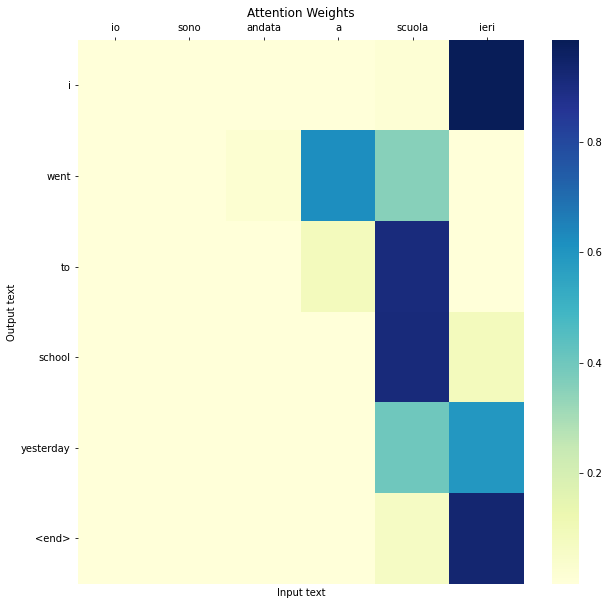

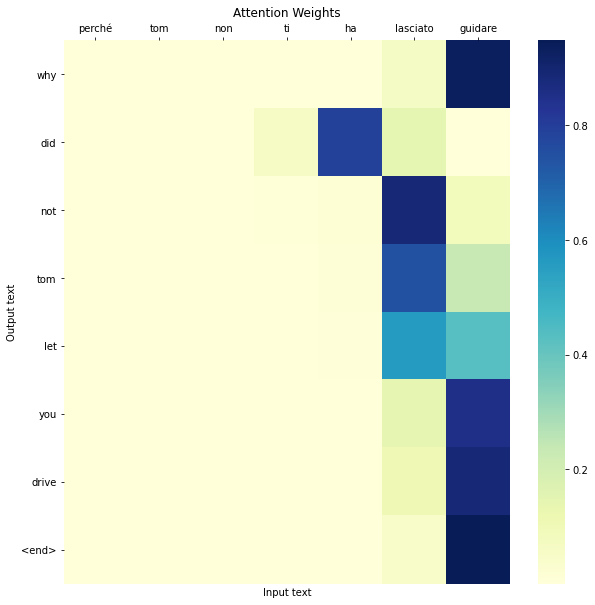

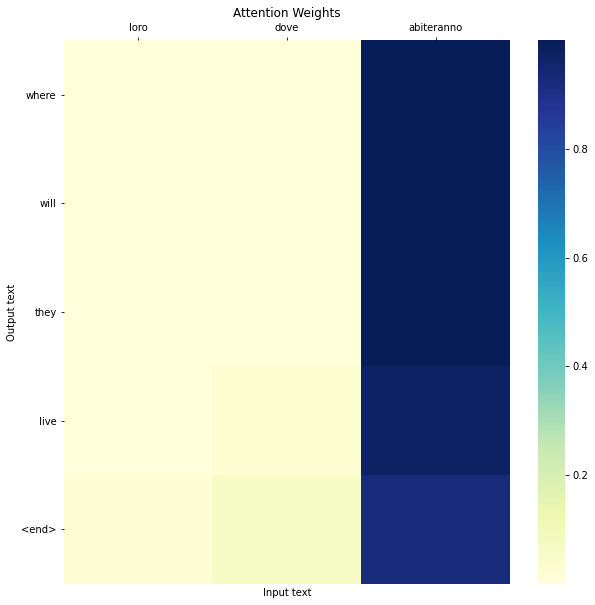

In [ ]:
# plotting attention weight matrix for 3 random test samples

for i in range(3):
  temp_df = df_test.sample(1)
  test_input = temp_df['itl'].values[0]
  plot_attention(test_input)

#### Calculate BLEU Score

In [ ]:
all_scores, avg_score = test_bleu(1000,df_test)
print(f'Average Blue Score for 1000 test samples: {avg_score}')

Average Blue Score for 1000 test samples: 0.7709246292959893


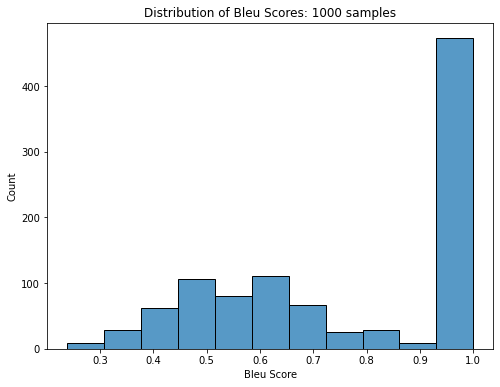

In [ ]:
# plotting distribution of Bleu Score 
plt.figure(figsize=(8,6))
plt.title("Distribution of Bleu Scores: 1000 samples")
plt.xlabel("Bleu Score")
sns.histplot(all_scores)
plt.show()

### Training - General Scoring

In [ ]:
# train and test data loader

train_dataset = Dataset(df_train,tokenizer_itl,tokenizer_eng,20)
test_dataset = Dataset(df_test,tokenizer_itl,tokenizer_eng,20)

train_dataloader = Dataloder(train_dataset,batch_size=1024)
test_dataloader = Dataloder(test_dataset,batch_size=1024)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [ ]:
train_steps = df_train.shape[0] // 1024
test_steps = df_test.shape[0] // 1024

In [ ]:
# defining callbacks

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor="val_loss",patience=2,mode="min")
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5,min_delta=0.005,min_lr=1e-8)
tensorboard = tf_callback(model_num=3)
callbacks = [early_stop,tensorboard, reduce_lr]

In [ ]:
# Compile the model and fit the model

tf.keras.backend.clear_session()
model = encoder_decoder(batch_size=1024,score_fun="general")
optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(optimizer=optimizer,loss=loss_function)
model.fit_generator(train_dataloader,steps_per_epoch=train_steps,epochs=50,validation_data=test_dataloader,validation_steps=test_steps,callbacks=callbacks)


Epoch 1/50
272/272 [==============================] - 122s 427ms/step - loss: 1.9836 - val_loss: 1.6454
Epoch 2/50
272/272 [==============================] - 112s 410ms/step - loss: 1.4939 - val_loss: 1.3954
Epoch 3/50
272/272 [==============================] - 111s 408ms/step - loss: 1.2470 - val_loss: 1.2127
Epoch 4/50
272/272 [==============================] - 111s 406ms/step - loss: 1.0823 - val_loss: 1.0610
Epoch 5/50
272/272 [==============================] - 111s 408ms/step - loss: 0.9480 - val_loss: 0.9324
Epoch 6/50
272/272 [==============================] - 111s 407ms/step - loss: 0.8317 - val_loss: 0.8217
Epoch 7/50
272/272 [==============================] - 110s 406ms/step - loss: 0.7293 - val_loss: 0.7105
Epoch 8/50
272/272 [==============================] - 120s 443ms/step - loss: 0.6416 - val_loss: 0.6297
Epoch 9/50
272/272 [==============================] - 110s 404ms/step - loss: 0.5702 - val_loss: 0.5645
Epoch 10/50
272/272 [==============================] - 111s 409m

#### Plot Attention Weights

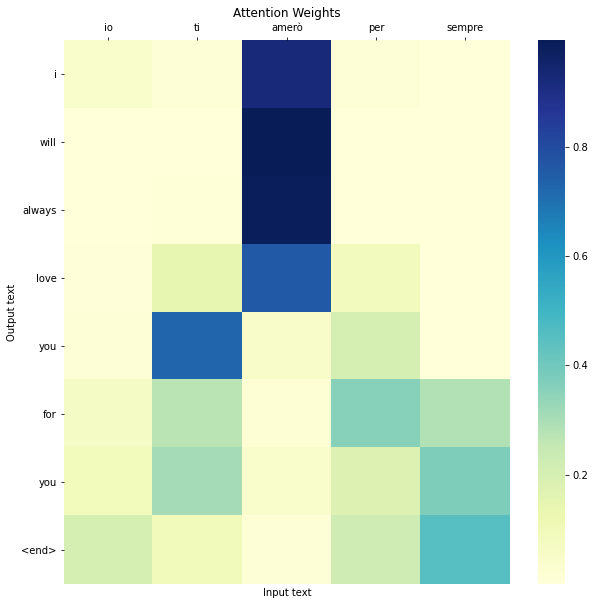

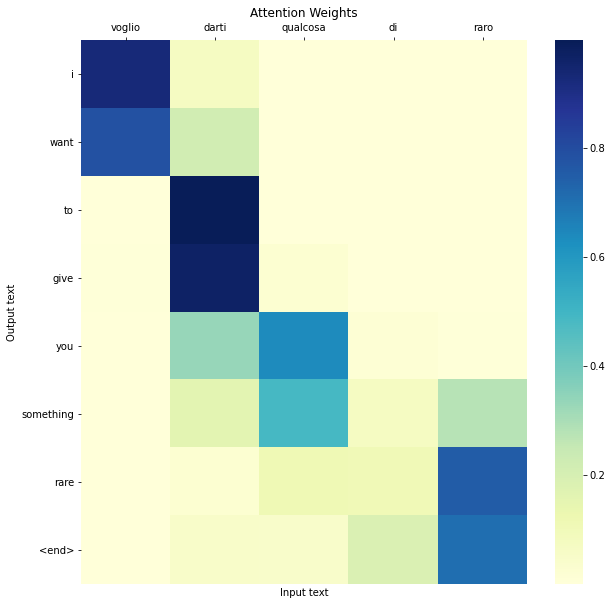

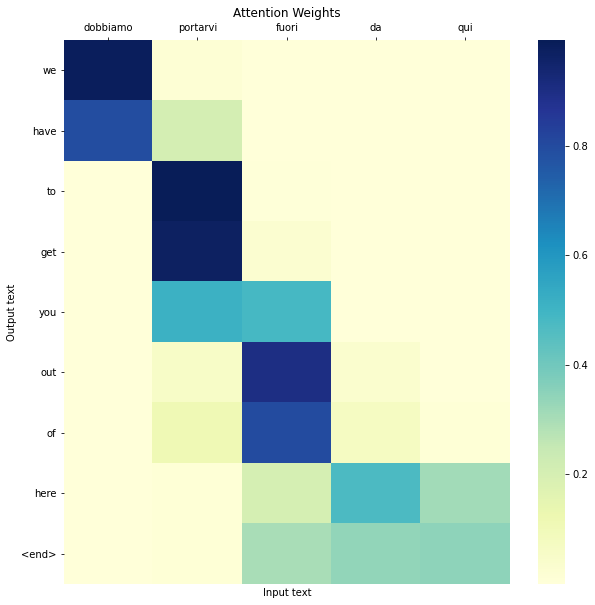

In [ ]:
# plotting attention weight matrix for 3 random test samples

for i in range(3):
  temp_df = df_test.sample(1)
  test_input = temp_df['itl'].values[0]
  plot_attention(test_input)

#### Compute Bleu Score

In [ ]:
all_scores, avg_score = test_bleu(1000,df_test)
print(f'Average Blue Score for 1000 test samples: {avg_score}')

Average Blue Score for 1000 test samples: 0.7786469406421939


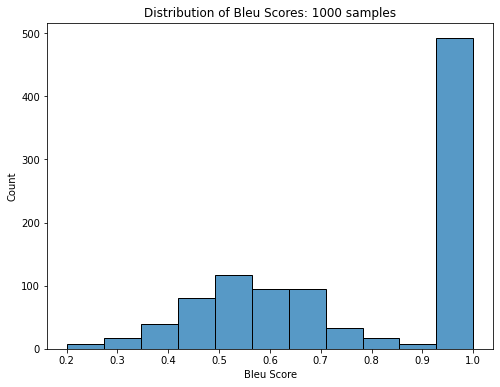

In [ ]:
# plotting distribution of Bleu Score 
plt.figure(figsize=(8,6))
plt.title("Distribution of Bleu Scores: 1000 samples")
plt.xlabel("Bleu Score")
sns.histplot(all_scores)
plt.show()

### Training -  Concat Scoring

In [ ]:
# train and test data loader

train_dataset = Dataset(df_train,tokenizer_itl,tokenizer_eng,20)
test_dataset = Dataset(df_test,tokenizer_itl,tokenizer_eng,20)

train_dataloader = Dataloder(train_dataset,batch_size=1024)
test_dataloader = Dataloder(test_dataset,batch_size=1024)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [ ]:
train_steps = df_train.shape[0] // 1024
test_steps = df_test.shape[0] // 1024

In [ ]:
# defining callbacks

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor="val_loss",patience=2,mode="min")
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5,min_delta=0.005,min_lr=1e-8)
tensorboard = tf_callback(model_num=4)
callbacks = [early_stop,tensorboard, reduce_lr]

In [ ]:
# Compile the model and fit the model

tf.keras.backend.clear_session()
model = encoder_decoder(batch_size=1024,score_fun="concat")
optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(optimizer=optimizer,loss=loss_function)
model.fit_generator(train_dataloader,steps_per_epoch=train_steps,epochs=50,validation_data=test_dataloader,validation_steps=test_steps,callbacks=callbacks)


Epoch 1/50
272/272 [==============================] - 128s 445ms/step - loss: 2.0168 - val_loss: 1.6869
Epoch 2/50
272/272 [==============================] - 117s 431ms/step - loss: 1.5349 - val_loss: 1.3695
Epoch 3/50
272/272 [==============================] - 118s 432ms/step - loss: 1.2596 - val_loss: 1.1462
Epoch 4/50
272/272 [==============================] - 118s 433ms/step - loss: 1.0684 - val_loss: 0.9813
Epoch 5/50
272/272 [==============================] - 118s 433ms/step - loss: 0.9117 - val_loss: 0.8333
Epoch 6/50
272/272 [==============================] - 118s 435ms/step - loss: 0.7868 - val_loss: 0.7268
Epoch 7/50
272/272 [==============================] - 117s 431ms/step - loss: 0.6883 - val_loss: 0.6401
Epoch 8/50
272/272 [==============================] - 117s 431ms/step - loss: 0.6105 - val_loss: 0.5767
Epoch 9/50
272/272 [==============================] - 117s 431ms/step - loss: 0.5486 - val_loss: 0.5235
Epoch 10/50
272/272 [==============================] - 117s 431m

#### Plot Attention Weights

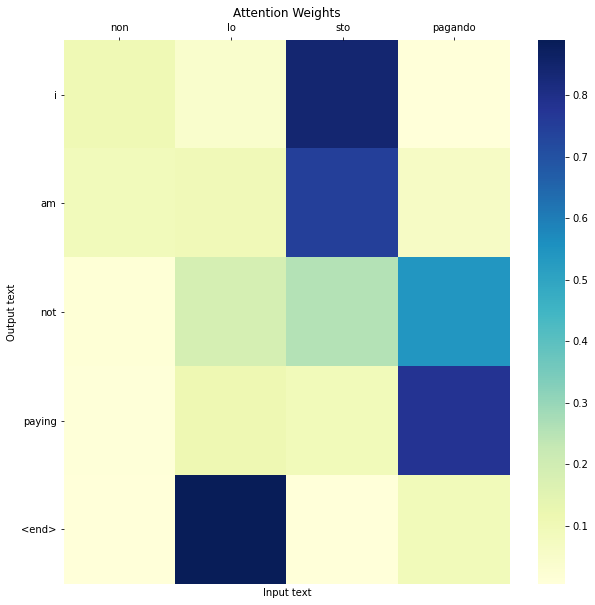

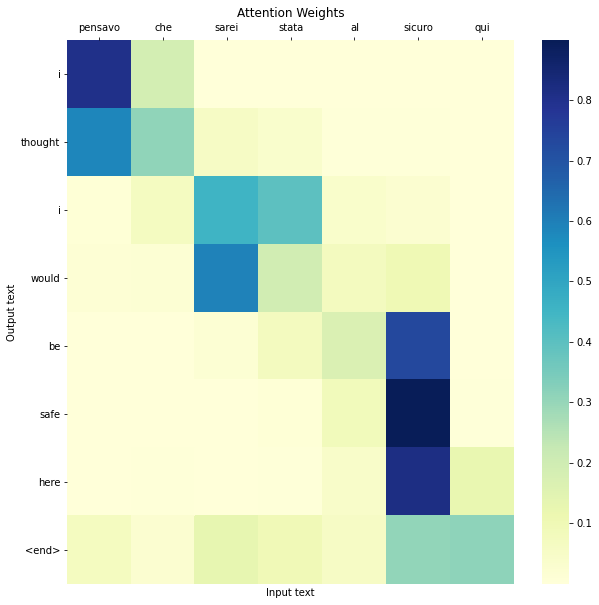

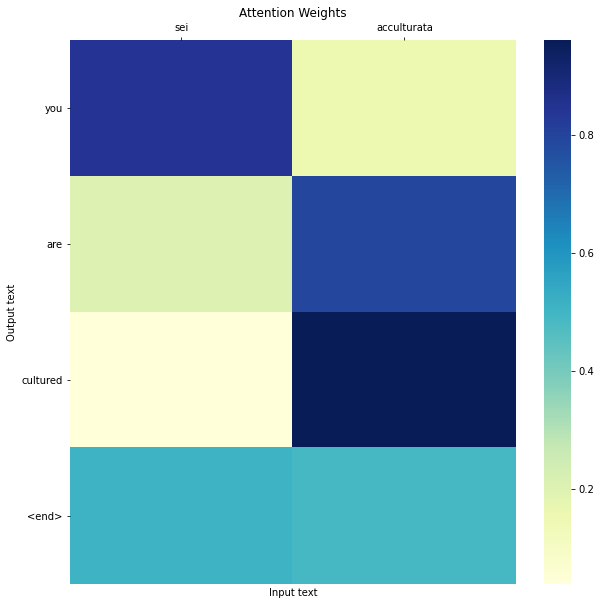

In [ ]:
# plotting attention weight matrix for 3 random test samples

for i in range(3):
  temp_df = df_test.sample(1)
  test_input = temp_df['itl'].values[0]
  plot_attention(test_input)

#### Compute Bleu Score

In [ ]:
all_scores, avg_score = test_bleu(1000,df_test)
print(f'Average Blue Score for 1000 test samples: {avg_score}')

Average Blue Score for 1000 test samples: 0.726438700639773


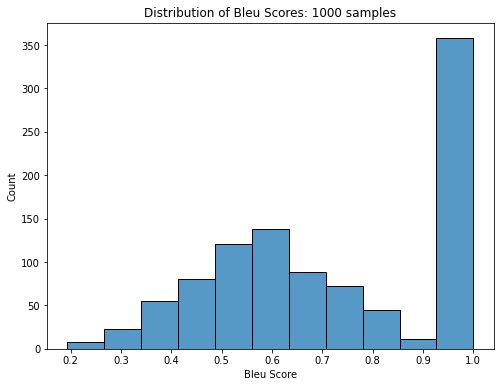

In [ ]:
# plotting distribution of Bleu Score 
plt.figure(figsize=(8,6))
plt.title("Distribution of Bleu Scores: 1000 samples")
plt.xlabel("Bleu Score")
sns.histplot(all_scores)
plt.show()